In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget "https://raw.githubusercontent.com/akshaycholapurath/DeepNNwithTensorflow/master/helper_function.py"

--2021-05-20 11:51:37--  https://raw.githubusercontent.com/akshaycholapurath/DeepNNwithTensorflow/master/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10475 (10K) [text/plain]
Saving to: ‘helper_function.py’

helper_function.py  100%[===================>]  10.23K  --.-KB/s    in 0s      

2021-05-20 11:51:37 (105 MB/s) - ‘helper_function.py’ saved [10475/10475]



In [4]:
from helper_function import pred_and_plot,load_and_prep_image,unzip_data,walk_through_dir, create_tensorboard_callback,plot_loss_curves,compare_historys

In [26]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-565cdba3-dd01-16b9-e139-fb1eff3c06bf)


In [8]:
#Use tensorflow datasets to get the data
import tensorflow_datasets as tfds

(train_data,test_data), ds_info = tfds.load(name='food101',split = ['train','validation'],
                                            shuffle_files = True,with_info = True,
                                            as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteHZCJ4T/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteHZCJ4T/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [23]:
train_one_sample = train_data.take(1)

In [17]:
class_names = ds_info.features['label'].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [18]:
for image, label in train_one_sample:
  print(f""" Image shape:{image.shape},Image datatype: {image.dtype}
          Class name: {class_names[label.numpy()]}""")

 Image shape:(382, 512, 3),Image datatype: <dtype: 'uint8'>
          Class name: gyoza


In [19]:
image

<tf.Tensor: shape=(382, 512, 3), dtype=uint8, numpy=
array([[[207, 220, 237],
        [207, 220, 237],
        [207, 220, 236],
        ...,
        [ 10,  11,  13],
        [ 11,  12,  14],
        [ 12,  13,  15]],

       [[208, 219, 237],
        [207, 220, 236],
        [208, 220, 236],
        ...,
        [  9,  10,  12],
        [ 10,  11,  13],
        [ 11,  12,  14]],

       [[216, 225, 242],
        [213, 225, 239],
        [214, 223, 238],
        ...,
        [ 11,  12,  14],
        [ 12,  13,  15],
        [ 12,  13,  15]],

       ...,

       [[ 33,  10,  16],
        [ 34,  11,  17],
        [ 33,  12,  17],
        ...,
        [ 10,   6,   5],
        [ 13,   7,   7],
        [ 15,   9,   9]],

       [[ 37,  12,  18],
        [ 36,  13,  19],
        [ 35,  15,  17],
        ...,
        [ 14,  10,   9],
        [ 19,  13,  13],
        [ 21,  15,  15]],

       [[ 39,  14,  20],
        [ 37,  14,  20],
        [ 36,  14,  17],
        ...,
        [ 19,  15,  1

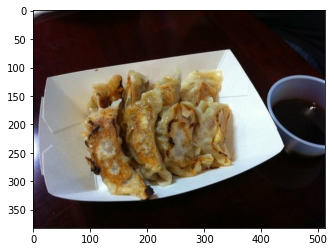

In [24]:
plt.imshow(image)

Create preprocessing functions for Data
Reshape the image to (224,224)
Convert dtype to float32

In [25]:
def preprocess_img(image,label,img_shape=224):
  image = tf.image.resize(image,size=[img_shape,img_shape])
  return tf.cast(image,tf.float32),label


In [27]:
#Map preprocessing function to training

train_data = train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)

In [28]:
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE )

In [33]:
#Map preprocessing function to testing data

test_data = test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)

In [34]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <ParallelMapDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [35]:
#Checkpoint callback

checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_acc',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [36]:
#Setup mixed precision training

from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

#Create models with Functional API
import tensorflow as tf

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)
x = base_model(inputs,training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
outputs = tf.keras.layers.Dense(10,activation="softmax",dtype=tf.float32)(x)

model_0 = tf.keras.Model(inputs,outputs)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


16711680/16705208 [==============================] - 0s 0us/step


In [37]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pooling (GlobalAv (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [38]:
model_0.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

In [40]:
history_0  = model_0.fit(train_data,epochs=3,
                         steps_per_epoch = len(train_data),
                         validation_data = test_data,
                         validation_steps = len(test_data),
                         callbacks=[create_tensorboard_callback(dir_name='training_logs',
                                                               experiment_name='efficientnet'),model_checkpoint]
                        )

Saving TensorBoard log files to: training_logs/efficientnet/20210520-130440
Epoch 1/3
2368/2368 [==============================] - 267s 97ms/step - loss: nan - accuracy: 0.0132 - val_loss: nan - val_accuracy: 0.0130


Epoch 2/3
1037/2368 [============>.................] - ETA: 1:26 - loss: nan - accuracy: 0.0149

KeyboardInterrupt: ignored